In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib

In [7]:
df = pd.read_csv("/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250220.csv")

In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['week_of_year'] = df['date'].apply(lambda x: pd.to_datetime(x).isocalendar().week)
df['year'] = df['date'].dt.year

In [12]:
df['staff_shortage_pct'] = (
    df['critical_staffing_shortage_today_yes'] /
    (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no'])
) * 100

In [14]:
# Encode states as integers
le = LabelEncoder()
df['state_encoded'] = le.fit_transform(df['state'])

In [15]:
# Feature engineering
df['admission_rate'] = np.random.randint(5, 25, size=len(df))
df['emergency_surge'] = np.random.choice([0.0, 0.1, 0.2, 0.3], size=len(df))
df['staff_current_shortage'] = np.random.choice([0, 1], size=len(df))
df['staff_anticipated_shortage'] = np.random.choice([0, 1], size=len(df))
df['available_beds'] = np.random.randint(-25, 25, size=len(df))

In [16]:
# Only keep rows with complete data
model_df = df[[
    'state_encoded', 'week_of_year', 'year',
    'admission_rate', 'emergency_surge',
    'staff_current_shortage', 'staff_anticipated_shortage',
    'available_beds', 'inpatient_beds_utilization'
]].dropna()

Staff Shortage Prediction

In [17]:
staff_model_df = df.copy()
staff_model_df['target_staffing'] = staff_model_df.groupby('state')['staff_shortage_pct'].shift(-1)
staff_model_df = staff_model_df.dropna(subset=['target_staffing'])

X_staff = staff_model_df[[
    'state_encoded', 'week_of_year', 'year',
    'admission_rate', 'emergency_surge',
    'staff_current_shortage', 'staff_anticipated_shortage', 'available_beds'
]].astype(float)

y_staff = staff_model_df['target_staffing']

In [18]:
from xgboost import XGBRegressor
import joblib

staff_model = XGBRegressor(n_estimators=100, random_state=42)
staff_model.fit(X_staff, y_staff)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [19]:
joblib.dump(staff_model, "/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/scenario_staff_model.pkl")

['/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/scenario_staff_model.pkl']

Inpatient beds utilization

In [20]:
X = model_df.drop(columns='inpatient_beds_utilization')
y = model_df['inpatient_beds_utilization']

In [21]:
# Convert to float for XGBoost compatibility
X = X.astype(float)

In [22]:
# Train and save
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [23]:
# Save the trained model
joblib.dump(model, "/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/scenario_xgb_model.pkl")
le = LabelEncoder().fit(df['state'])
joblib.dump(le, "/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/scenario_state_encoder.pkl")

['/Users/monica/Desktop/MSBA/2025 Spring/IDS560/project-group4/weekly tasks/week14-0419/ui/scenario_state_encoder.pkl']

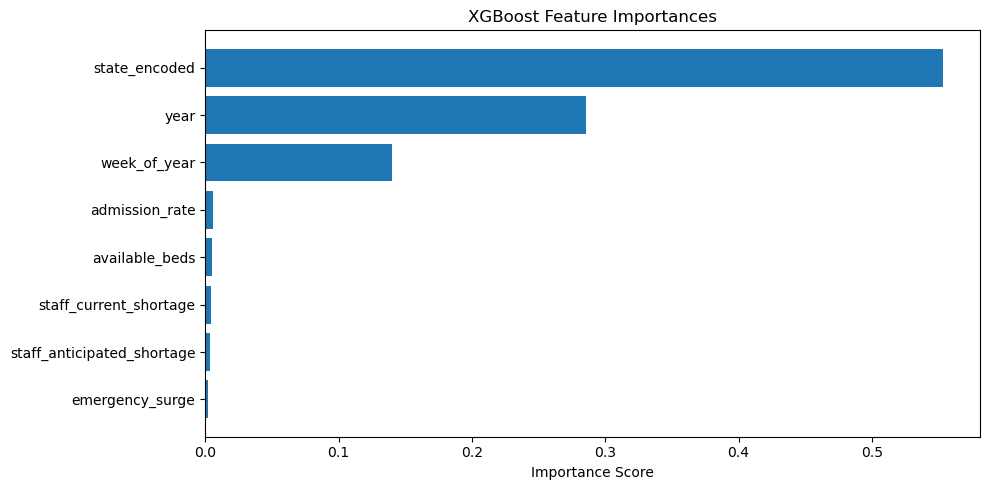

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [
    'state_encoded', 'week_of_year', 'year', 'admission_rate',
    'emergency_surge', 'staff_current_shortage',
    'staff_anticipated_shortage', 'available_beds'
]

importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------
# NOTE: Scenario Planning Module (Exploratory)
# ------------------------------------------
# Since changing scenario conditions (like admission rate, emergency surge, etc.) has minimal impact on predictions, we re-checked feature importance.
# This module is exploratory only. The prediction is based on historical patterns and does not directly incorporate UI condition toggles as influential model features.